# 8.1 Mathematical tools for image formation

Image formation is the process of projecting the elements appearing in a **3D scene** (objects, surfaces, landscapes, etc.) on a **2D image plane**. This process happens, for instance, when you are capturing an image of the real world by means of a camera, or when you are playing a first-person videogame and the 3D virtual environment of the game is projected to a plane that is shown to you as the player's view.
<table>
<tr><td><img src="./images/intro.jpg" width="600"/></td>
    <td><img src="./images/videogame.png" width="400"/></td>
<tr>
</table>

The *image formation* topic involves two different perspectives of the problem of generating images from 3D scenes:

- **The geometric problem:** Where does each 3D point project on the image? 
- **The radiometric problem:** What will be the color on the image of each 3D point? *(not addressed here)*

In this introductory notebook, we will see some basic mathematical tools that are required for studying image formation models as the common pinhole model. Although it might seem at first that they are not related with the problem at hand, their understanding is of capital importance when studying about elements and transformations between the 3D world and the 2D image plane. 

These tools include:

- **Euclidean transformations in 3D**.
  - Introducing and displaying vectors (8.1.1).
  - Products of 3D vectors (8.1.2).
  - Linear transformation of vectors (8.1.3).
  - Rotation matrix (8.1.4).
- ***Next notebook:*** **Homogeneous transformations (8.2)**.

## Problem context - Camera in first-person videogames 

In video games, it is called *first person* to any graphical perspective rendered from the viewpoint of the player's character, or a viewpoint from the cockpit or front seat of a vehicle driven by the character. Many genres incorporate first-person perspectives, including adventure games, driving, sailing, and flight simulators. Perhaps the more extended are first-person shooters, in which the graphical perspective is an integral component of the gameplay.

Usually, when someones plays a first-person computer game, the `WASD` keys of our keyboard are used to move the camera position in the $x$ and $z$ axes (planar movement) and `SPACE` is used for jumping (this moves the camera in the $y$ axis, hence allowing it to move in 3D). Then, the mouse is used for changing the camera orientation (this applies *pitch* and/or *yaw* rotations to the camera coordinate system). The combination of 3D movement and 3D rotations creates a full 6D movement control for our character!

<img src="./images/first_person.jpg" width="500"/>$\\[3pt]$

Our task in this notebook is **to program these camera displacements and rotations so they can be integrated into a graphic engine!**. Obviously, this implies learning all the maths involved in here, and most of them are related to the manipulation of vectors and matrices. So, let's start the fun!

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, radians
%matplotlib notebook

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
images_path = './images/'

## 3D Euclidean transformations

## 8.1.1 Introducing and displaying vectors

Since we are going to employ lots of vectors in this notebook (and the following ones), first of all, we need to know how vectors are defined and how to transform them.

We consider two different types of vectors:

- A **bound vector** defined by two points $\{\mathbf{p},\mathbf{q}\}$:

$\hspace{2cm} \mathbf{p} = \begin{bmatrix} p_1 \\ p_2 \\ p_3\end{bmatrix} \in \mathbb{R}^3, \ \mathbf{q} = \begin{bmatrix} q_1 \\ q_2 \\ q_3 \end{bmatrix} \in \mathbb{R}^3 \\[5pt]$

- A **free vector** $\mathbf{v}$ (or just vector) that can be defined as a mathematical entity represented as an *oriented segment* between two points, whose elements (in 3D) can be computed as:

$\hspace{2cm} \mathbf{v} = \begin{bmatrix} v_1 \\ v_2 \\ v_3\end{bmatrix} = \begin{bmatrix} q_1  - p_1 \\ q_2 - p_2  \\ q_3 - p_3 \end{bmatrix} \in \mathbb{R}^3$


This way, different bound vectors can share the same free vector (indeed a free vector is defined as the set of bound vectors having the same module, orientation and direction).

Note from the notation in $\mathbf{p}$, for example, that a vector can also represent the coordinates of a certain point with respect to the origin of coordinates. In fact, in this notebook, we will use vectors to refer to several entities such as points, axes or even transformations (translations). 

Thus, it is important to know how to draw them, in order to have a visual reference of what we are using! In python, we can plot a set of 3D vectors using matplotlib's method [`quiver()`](https://matplotlib.org/3.1.1/gallery/mplot3d/quiver3d.html), which takes 6 main arguments:

- `X,Y,Z`: tuples containing the *X*, *Y* and *Z* coordinates of the origin point in the set of vectors.
- `U,V,W`: tuples containing the *X*, *Y* and *Z* coordinates of all vectors w.r.t. such origin point.

The next code illustrates how to plot two free vectors $\mathbf{v}_1 = (2,1,1)$, and $\mathbf{v}_2 = (0,1,2)$, with origin point $\mathbf{p}=(1,1,1)$

<IPython.core.display.Javascript object>


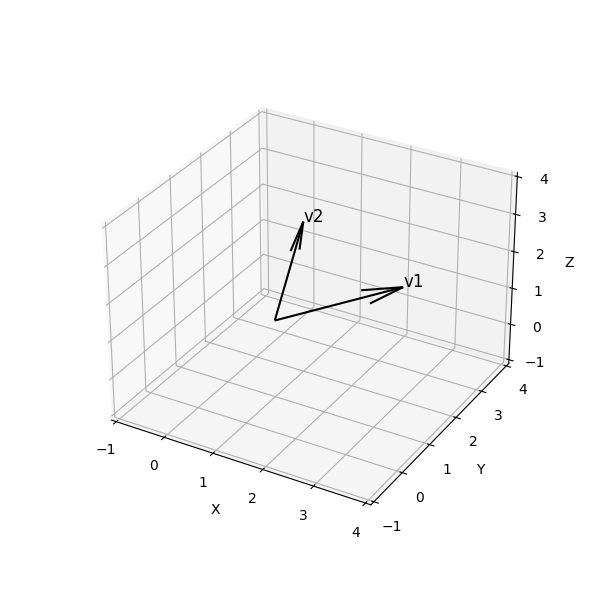

In [2]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Vector coordinates
v1 = np.array([2,1,1])
v2 = np.array([0,1,2])
v = np.column_stack((v1,v2))

# Vector labels
labels = ["v1","v2"]

# Origin coordinates
p = np.array([1,1,1])
origin = np.column_stack((p,p))

# Prepare vector for plotting input
X,Y,Z = origin[0,:], origin[1,:], origin[2,:]
U,V,W = v[0,:], v[1,:], v[2,:]

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection="3d")

# Set axes limits
ax.set_xlim3d(-1, 4)
ax.set_ylim3d(-1, 4)
ax.set_zlim3d(-1, 4)

# Add axis labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_aspect('equal')

# Plot vectors
ax.quiver(X, Y, Z, U, V, W, color="black")

# Add labels
for i in range(len(labels)):
    ax.text(U[i]+X[i], V[i]+Y[i], W[i]+Z[i] ,labels[i], fontsize=12)

# And show the figure!
plt.show()

## <span style="color:green"><b><i>ASSIGNMENT 1a: We want to see how these things work</i></b></span>

Let's convert the previous code displaying vectors in a method that we can use later. **Your first task is** to define the method called `plot_vectors()`, which returns a figure plotting a number of input free vectors as defined in `v` with a given `origin` and axes `labels`. 

Note that:

- This function also expects as inputs a figure and some axes. This permits us to call the method **multiple times** while working the same figure.
- For that, the first time that the method is called, the axes must be previously initialized outside the method. You can use [ax = fig.gca(projection='3d')](https://kite.com/python/docs/matplotlib.figure.Figure.gca) for that.
- You also have to permit to introduce the axes limits as argument, to select the area of the plot we want to see.

In [3]:
# ASSIGNMENT 1
def plot_vectors(fig, ax, v, origin, labels, color, axes_lim):
    """ Plot 3D vectors using matplotlib
        
        Args:
            fig, ax: Figure and axes (must be 3D)
            v: Array containing vector coordinates, each column contains a 3D vector
            origin: Array containing vector origin points for 'v' array
            labels: Array of strings containing labels for the vectors, it should have same length than columns in 'v'
            color: String containing the color of the vectors
            axes_lim: 6-size vector containing the minimum and maximum limits for each axis [X_min,X_max,X_min,X_max,Z_min,Z_max]
        
        Returns: 
            fig, ax: Figure and axis of a 3D plot with the vectors plotted
    """   
    # Write your code here

    # Prepare vector for plotting input
    X,Y,Z = origin[0,:], origin[1,:], origin[2,:]
    U,V,W = v[0,:], v[1,:], v[2,:]
    # Set axes limits
    ax.set_xlim3d(axes_lim[0], axes_lim[1])
    ax.set_ylim3d(axes_lim[0], axes_lim[1])
    ax.set_zlim3d(axes_lim[0], axes_lim[1])
    
    # Add axis labels and aspect ratio
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    #ax.set_aspect('equal')
    
    # Plot vectors
    ax.quiver(X, Y, Z, U, V, W, color="black")
    
    # Add labels
    for i in range(len(labels)):
        ax.text(U[i]+X[i], V[i]+Y[i], W[i]+Z[i], labels[i], fontsize=12,color=color)

    return fig,ax

To **test your function**, the next code should show an orthonormal basis (unit vectors) centered at $\mathbf{p}_0=(0,0,0)$.
<img src="./images/ortho_base.png" width="350"/>$\\[3pt]$

<IPython.core.display.Javascript object>


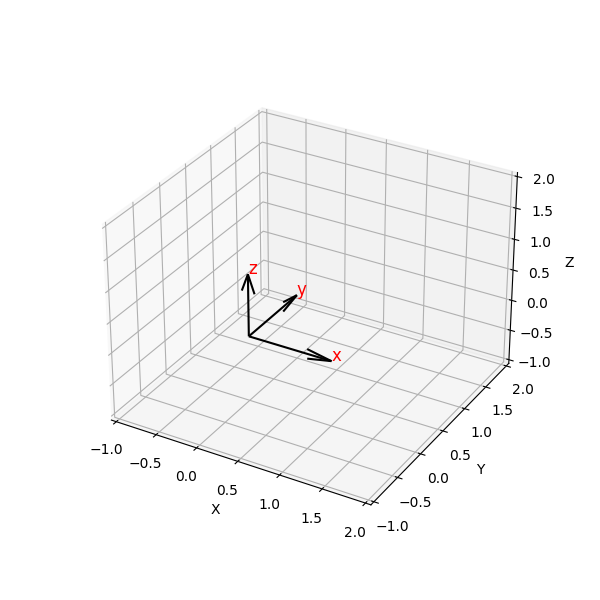

In [4]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')
   
# Vector coordinates
v = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Vector labels
labels = ["x","y","z"]

# Call plot_vectors
fig, ax = plot_vectors(fig, ax, v, origin, labels, "red", [-1,2,-1,2,-1,2])

fig.show()

## <span style="color:green"><b><i>ASSIGNMENT 1b: Plotting a free vector</i></b></span>

Let's make use of the `plot_vectors()` method for plotting a free vector `v` built from the coordinates of other two vectors `p` and `q`. Recall that:

$\hspace{2cm} \mathbf{v} = \begin{bmatrix} v_1 \\ v_2 \\ v_3\end{bmatrix} = \begin{bmatrix} q_1  - p_1 \\ q_2 - p_2  \\ q_3 - p_3 \end{bmatrix} \in \mathbb{R}^3$

As a result, the coordinates of the free vector `v` are expressed w.r.t. the endpoint of the `p` vector, that is, `p` is its origin. Consider the following definitions of vectors:

- $p = [1,1,1.5]$
- $q = [1.5,1,1]$

This is the result we are looking for:

<img src="./images/example_of_free_vector.png"/>$\\[3pt]$

<IPython.core.display.Javascript object>


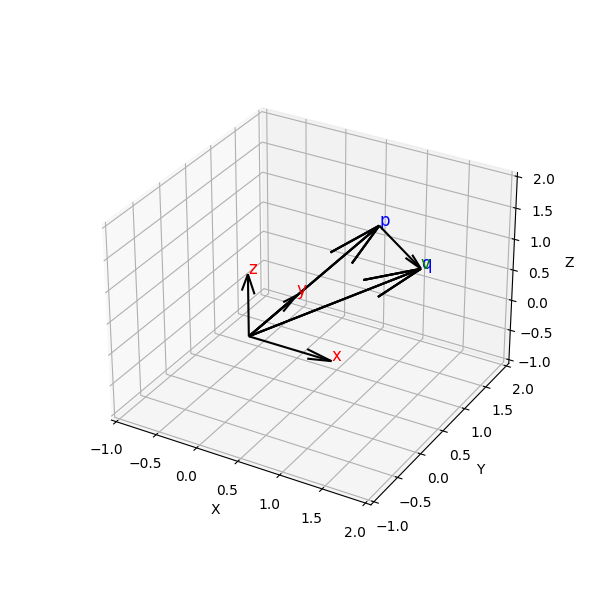

In [5]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')
   
# System of reference vector coordinates
v_o = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates of the reference system
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Define the vectors
p = np.vstack([1,1,1.5])
q = np.vstack([1.5,1,1])
v = q-p

# Define the origin of each vector
origin_p = np.vstack(origin)
origin_q = np.vstack(origin)
origin_v = p

# Vector labels
labels = ["x","y","z"]
labels_p = ["p"]
labels_q = ["q"]
labels_v = ["v"]

# Call plot_vectors
fig, ax = plot_vectors(fig, ax, v_o, origin, labels, "red", [-1,2,-1,2,-1,2])
fig, ax = plot_vectors(fig, ax, p, origin_p, labels_p, "blue", [-1,2,-1,2,-1,2])
fig, ax = plot_vectors(fig, ax, q, origin_q, labels_q, "blue", [-1,2,-1,2,-1,2])
fig, ax = plot_vectors(fig, ax, v, origin_v, labels_v, "green", [-1,2,-1,2,-1,2])

fig.show()

## 8.1.2 Product of 3D vectors

Now that you know how to define and plot a set of vectors, you are ready to learn two basic operations with them: the **dot** and **cross** products.

### Dot product of two vectors

The dot product (also called scalar product or inner product) of two vectors is the sum of the element-wise product between them, which results in a **scalar**.

***Algebraic definition:***

$$ \mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \\ a_3\end{bmatrix} \;\;\;\;\;\;  \mathbf{b} = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix}$$

$$\langle\mathbf{a},\mathbf{b}\rangle = \mathbf{a} \cdot \mathbf{b} = \mathbf{a}^\texttt{T}\mathbf{b} = \texttt{trace}(\mathbf{a} \, \mathbf{b}^\texttt{T}) = a_1b_1 + a_2b_2 + a_3b_3 \in \mathbb{R}$$

The dot product is involved in the definition of the **Euclidean norm** of a vector, which, geometrically, represents the distance between the two points that delimits the vector:

$$\|\mathbf{a}\| = \sqrt{\mathbf{a}^\texttt{T}\mathbf{a}} = \sqrt{a_1^2 + a_2^2 + a_3^2}$$

***Geometric definition:*** From a geometric point of view, the dot product of two vectors $\mathbf{a}$ and $\mathbf{b}$ is defined by:

$$ \mathbf{a}\cdot \mathbf{b} = \| \mathbf{a}\| \, \|\mathbf{b}\| \cos \theta$$

where $\theta$ is the angle between both vectors. That is, the dot product represents the product of their Euclidean norms and the cosine of the angle between them. Such a definition can be rearranged to calculate the projection of one vector onto the other as shown in the figure: $\\[5pt]$

<img src="./images/dot.png" width="300" align="center"/>

## **<span style="color:green"><b><i>ASSIGNMENT 2: Playing with the dot product</i></b></span>**

We are going to work with the vectors $\mathbf{a}=(0,1,0.5)$ and $\mathbf{b}=(1,1.5,1)$ and the dot product:

1. First of all, plot these vectors using `plot_vectors()`.

<IPython.core.display.Javascript object>


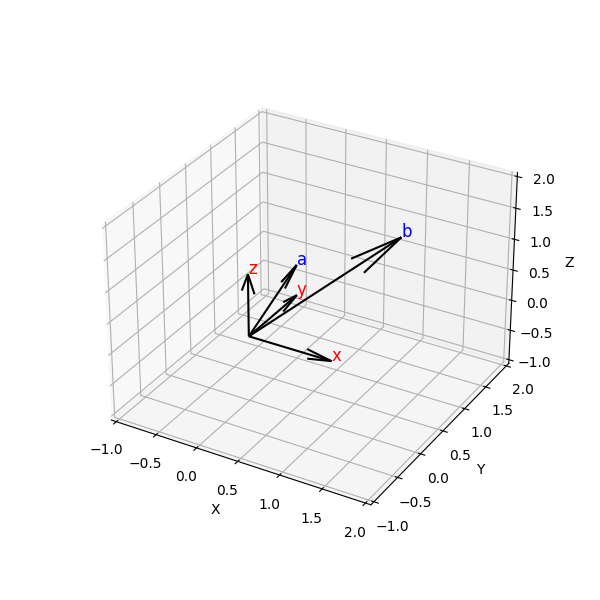

In [6]:
# ASSIGNMENT 2
# Write your code here!

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')
   
# Vector for basis coordinates
v_o = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Matrix of vectors
a = np.array([0,1,0.5])
b = np.array([1,1.5,1])
v = np.column_stack((a,b))

origin_v = np.column_stack(([0,0,0],[0,0,0]))

# Vector labels
labels = ["x","y","z"]
labels_v = ["a","b"]

# Call plot_vectors
fig, ax = plot_vectors(fig, ax, v_o, origin, labels, "red", [-1,2,-1,2,-1,2])
fig, ax = plot_vectors(fig, ax, v, origin_v, labels_v, "blue", [-1,2,-1,2,-1,2])

fig.show()

2. Now, compute the **dot product** of these vectors using the described **algebraic** method. Check that you get the same result as using [`np.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html). 


In [7]:
# Dot product (algebraic)
dot = sum(a * b)
dot_np = np.dot(a, b)

print('Dot product     : ' + str(dot))
print('Dot product (np): ' + str(dot_np))

Dot product     : 2.0
Dot product (np): 2.0


<font color='blue'>**Expected output:**  </font>

    Dot product     : 2.0
    Dot product (np): 2.0

3. Finally, let's take a look at the geometric interpretation of the dot product. For that, compute the norms of both vectors, and compute the projection of the first vector `a` onto the second one `b`, that is:
$$ \frac{\mathbf{a}\cdot \mathbf{b}}{\|\mathbf{b}\|}$$
Check that you get the same norm than using [`np.linalg.norm()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

In [8]:
# Norm of second vector
norm_a = sum(a * a)**(1/2) # Norm of the first vector
norm_b = sum(b * b)**(1/2) # Norm of the second vector
norm_a_np = np.linalg.norm(a)
norm_b_np = np.linalg.norm(b)

# Projection of first vector a onto the second one b
projection = dot/norm_b

print("a norm     : " + str(round(norm_a,2)))
print("b norm     : " + str(round(norm_b,2)))
print("a norm (np): " + str(round(norm_a_np,2)))
print("b norm (np): " + str(round(norm_b_np,2)))
print("\nProjection of a onto b: " + str(round(projection,2)))

a norm     : 1.12
b norm     : 2.06
a norm (np): 1.12
b norm (np): 2.06

Projection of a onto b: 0.97


<font color='blue'>**Expected output:**  </font>

    a norm     : 1.12
    b norm     : 2.06
    a norm (np): 1.12
    b norm (np): 2.06

    Projection of a onto b: 0.97

### Cross product of two vectors

The cross product of two linearly independent vectors $\mathbf{a}$ and $\mathbf{b}$ (also called vector product) is a linear transformation which results in **another vector** $\mathbf{c}$ perpendicular to both, and thus to the plane containing them. Given two vectors:$\\[5pt]$

$$ \mathbf{a} = \begin{bmatrix} a_1 \\ a_2 \\ a_3\end{bmatrix} \hspace{1cm} \mathbf{b} = \begin{bmatrix} b_1 \\ b_2 \\ b_3 \end{bmatrix} \\[5pt]$$

Their cross product is defined as: $\\[10pt]$
$$ \mathbf{c} = \mathbf{a} \times \mathbf{b} = \begin{vmatrix}
i & j & k \\
a_1 & a_2 & a_3 \\
b_1 & b_2 & b_3
\end{vmatrix}
= 
(a_2 b_3 \mathbf{i} + a_3 b_1 \mathbf{j} + a_1 b_2 \mathbf{k}) - (a_3 b_2 \mathbf{i} + a_1 b_3 \mathbf{j} + a_2 b_1 \mathbf{k})
= 
(a_2 b_3 - a_3 b_2)\mathbf{i} + (a_3 b_1 - a_1 b_3)\mathbf{j} + (a_1 b_2 - a_2 b_1)\mathbf{k}
$$

Although it is more convenient to express it as a linear transformation using matrix multiplication:

$$ \mathbf{c} = \mathbf{a} \times \mathbf{b} 
= [\mathbf{a}]_\times\mathbf{b} \hspace{1.5cm} / \hspace{1.5cm} [\mathbf{a}]_\times = \begin{bmatrix} 0 & -a_3 & a_2 \\ a_3 & 0 & -a_1 \\ -a_2 & a_1 & 0\end{bmatrix}  \in \mathbb{R}^3$$

where $[\mathbf{a}]_\times$ is called the *skew-symmetric* matrix of $\mathbf{a}$. It is often denoted as $\hat{ \mathbf{a}}$.

The norm of the resultant vector is computed as:

$$ \|\mathbf{c}\| = \|\mathbf{a}\| \, \|\mathbf{b}\| \sin \theta$$

This has an interesting **geometric meaning**: the norm of the cross product of two vectors $\mathbf{a}$ and $\mathbf{b}$ can be interpreted as the area of the parallelogram that has such vectors as sides. Also, as mentioned before, the resulting vector is orthogonal to both $\mathbf{a}$ and $\mathbf{b}$ vectors:

<img src="./images/cross.png" width="200" align="center"/>

## **<span style="color:green"><b><i>ASSIGNMENT 3: It's cross product time</i></b></span>**

Let's play with the cross product! For that **you are tasked to**: 

1. Compute the cross product of two vectors $\mathbf{a}=[1,1,4]$ and $\mathbf{b}=[2,3,1]$ **using matrix multiplication** (that is, using $\hat{\mathbf{a}}$) and check that you get the same result as using `np.cross()`. 
2. Compute the norm of the resultant vector $\mathbf{c}$ which, as commented, represents the area of the parallelogram that has $\mathbf{a}$ and $\mathbf{b}$ as sides.
3. Then plot $\mathbf{a}$ and $\mathbf{b}$ as black vectors and their cross product $\mathbf{c}$ in red using your previous method `plot_vectors()`.

*Tip: In numPy, matrix multiplication is defined with the `@` operator (`A @ B`) instead of the* `*` *operator, which performs element-wise matrix multiplication. To transform a horizontal vector (row) to a vertical vector (column) you can use [`np.vstack()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html).*

a x b     : [-11   7   1]
a x b (np): [-11   7   1]
Norm of c : 13.08


<IPython.core.display.Javascript object>


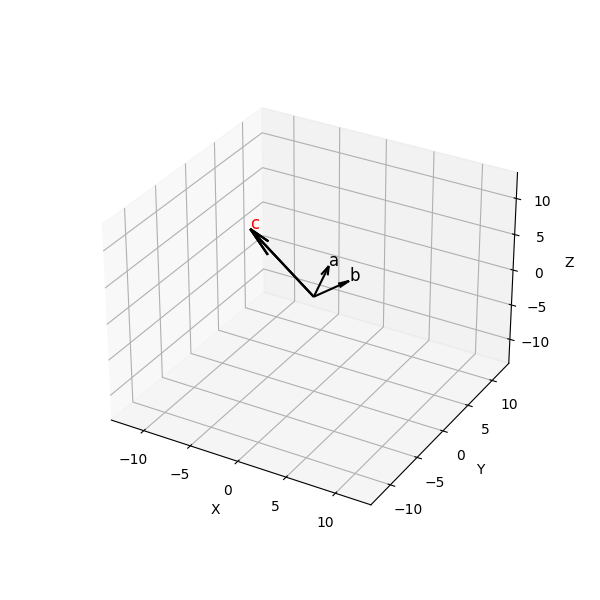

In [9]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# ASSIGNMENT 3
# Write your code here!

# Vectors coordinates
v = np.array([[1,2],[1,3],[4,1]])

# Vector origin points
origin = np.array([[0,0],[0,0],[0,0]])

# Isolate vectors
a = v[:,0]
b = v[:,1]

# Compute â
hat_a = np.array([
    [0,-a[2],a[1]],
    [a[2],0,-a[0]],
    [-a[1],a[0],0]
])

# Compute cross product
cross = hat_a @ b
cross_np = np.cross(a,b)

print('a x b     : ' + str(cross))
print('a x b (np): ' + str(cross_np))

# Compute the norm of c = a x b 
norm_c = np.linalg.norm(cross)

print('Norm of c : ' + str(round(norm_c,2)))

# Transform to vertical vector
cross = np.vstack(cross)

# Create figure
fig = plt.figure()

# Prepare figure for 3D data
ax = fig.gca(projection='3d')
axes_lim = [-13,13,-13,13,-13,13]

# Call plot_vectors
fig, ax = plot_vectors(fig, ax, v, origin, ["a","b"], "black", axes_lim)
fig, ax = plot_vectors(fig, ax, cross, np.array([[0,0,0],[0,0,0],[0,0,0]]), ["c"], "red", axes_lim)

plt.show()

<font color='blue'>**Expected output:**  </font>
    
    a x b     : [-11   7   1]
    a x b (np): [-11   7   1]
    Norm of c : 13.08

### Extra: product of three vectors

The product of three vectors (or scalar triple product) is a combination of the two previous ones: it is defined as the dot product of a vector $\mathbf{c}$ with the cross product of the other two, namely $\mathbf{a}$ and $\mathbf{b}$, that is:

$$(\mathbf{a} \times \mathbf{b}) \cdot \mathbf{c}$$

This product also has a **geometric meaning**: it is the (signed) volume of the parallelepiped defined by those vectors:$\\[10pt]$

<img src="./images/triple.png" width="250"/>$\\[3pt]$

## **<span style="color:green"><b><i>ASSIGNMENT 4: Concluding with the triple product</i></b></span>**

Compute the triple product of $\mathbf{a}=(1,2,3)$, $\mathbf{b}=(3,1,2)$ and $\mathbf{c}=(2,2,1)$:

In [10]:
# ASSIGNMENT 4
# Write your code here!

# Vector coordinates
a = np.array([1,2,3])
b = np.array([3,1,2])
c = np.array([2,2,1])
v = np.column_stack((a,b,c))

#Isolate vectors
a = v[:,0]
b = v[:,1]
c = v[:,2]

# Compute â
hat_a = np.array([
    [0,-a[2],a[1]],
    [a[2],0,-a[0]],
    [-a[1],a[0],0]
])

# Compute cross product
cross = hat_a @ b

# Compute triple product
triple_product = cross @ c
# triple_product = np.dot(np.cross(a,b),c)

print('Triple product:', triple_product)

Triple product: 11


<font color='blue'>**Expected output:**  </font>

       Triple product: 11

## 8.1.3 Linear transformation of vectors

As we saw before, the cross product of two vectors is a linear transformation, i.e., a linear function that transforms the elements of the involved vectors. But the cross product is just one particular case of linear transformation where the matrix that defines such linear function is created from the elements of a vector. A more general definition for linear transformations in the 3D-space would be:

$$\mathbf{A}\mathbf{v} = \begin{bmatrix} a_1 & a_2 & a_3 \\ a_4 & a_5 & a_6 \\ a_7 & a_8 & a_9 \end{bmatrix} \begin{bmatrix} v_1 \\ v_2 \\ v_3\end{bmatrix} =  \begin{bmatrix} a_1v_1 + a_2v_2 + a_3v_3 \\ a_4v_1 + a_5v_2 + a_6v_3 \\ a_7v_1 + a_8v_2 + a_9v_3\end{bmatrix}$$

Note that we can stack a set of $N$ **column** vectors $\{\mathbf{v}_i\}$ forming a $3\times N$ matrix $\mathbf{V}$ so that the linear transformation is applied to every individual vector. The resulting matrix will be a **stack of transformed column vectors**.

$$\mathbf{A}\mathbf{V} = \mathbf{A}\begin{bmatrix} \mathbf{v}_1 & \mathbf{v}_2 & \cdots & \mathbf{v}_N\end{bmatrix} = \begin{bmatrix} \mathbf{A}\mathbf{v}_1 & \mathbf{A}\mathbf{v}_2 & \cdots & \mathbf{A}\mathbf{v}_N \end{bmatrix}$$

This property will be extremelly useful when implementing transformations that must be applied to a large number of points.

But, what means that an operation (in this case a matrix multiplication) is linear? It means that the following two properties hold:

- **Aditivity:** $f(\mathbf{x}_1 + \mathbf{x}_2) = f(\mathbf{x}_1) + f(\mathbf{x}_2)$$\\[5pt]$
- **Scaling:** $f(\alpha \mathbf{x}_1) = \alpha f(\mathbf{x}_1)$

And, equivalently, the superposition principle also holds:

- **Superposition:** $f(\alpha \mathbf{x}_1 + \beta \mathbf{x}_2) = \alpha f(\mathbf{x}_1) + \beta f(\mathbf{x}_2)$ 

Luckily, matrix multiplication satisfies this property!

$$\mathbf{A}(\alpha \mathbf{x}_1 + \beta \mathbf{x}_2) = \alpha \mathbf{A} \mathbf{x}_1 + \beta \mathbf{A} \mathbf{x}_2 = \alpha \mathbf{y}_1 + \beta \mathbf{y}_2$$

that is, the transformation of linear combinations of vectors $(\alpha \mathbf{x}_1 + \beta \mathbf{x}_2)$ is the linear combination of the transformed vectors $(\alpha \mathbf{y}_1 + \beta \mathbf{y}_2)$. The following figure shows an example of this property in action, given two vectors $\mathbf{x_1}=\begin{bmatrix}2 \\ 1\end{bmatrix}$ and $\mathbf{x_2}=\begin{bmatrix}1 \\ 0\end{bmatrix}$ with $\alpha = 1$ and $\beta = 2$, and a matrix $\mathbf{A}==\begin{bmatrix} 1 & 0 \\ 2 & 1\end{bmatrix}$:

<img src="./images/linear.png" align="center"/>

## **<span style="color:green"><b><i>ASSIGNMENT 5: Playing with linear transformations</i></b></span>**

Implement a complete method `apply_transformation()`, which:

1. transforms a set of vectors `v` according to a certain input transformation (matrix $\mathbf{A}$), and then 
2. shows the original vectors in black and the transformed ones in red. 

**Reuse the method** `plot_vectors()` for this assignment.

*NOTE: The labels for the transformed vectors should be the same that for the originals (but shown in red).*

In [11]:
# ASSIGNMENT 5
def apply_transformation(transformation, v, origin, labels, axes_lim):
    """ Apply a linear transformation to a set of 3D-vectors and plot them
        
        Args:
            transformation: 3x3 matrix that defines the linear transformation
            v: Array containing vector coordinates, each column contains a 3D vector
            origin: Array containing vector origin points for 'v' array
            labels: Array of strings containing labels for the vectors, it should have same length than columns in 'v'
            axes_lim: 6-size vector containing the minimum and maximum limits for each axis [X_min,X_max,X_min,X_max,Z_min,Z_max]
    """   
    # Write your code here!
    
    # Apply transformation
    transformed_v = transformation @ v
    
    # Create figure
    fig = plt.figure()

    # Prepare figure for 3D data
    ax = fig.gca(projection='3d')

    # Call plot_vectors
    fig, ax = plot_vectors(fig, ax, v, origin, labels, "black", axes_lim)
    fig, ax = plot_vectors(fig, ax, transformed_v, origin, labels, "red", axes_lim)

    plt.show()

You can use the next code **to test if your results are correct**:

<IPython.core.display.Javascript object>


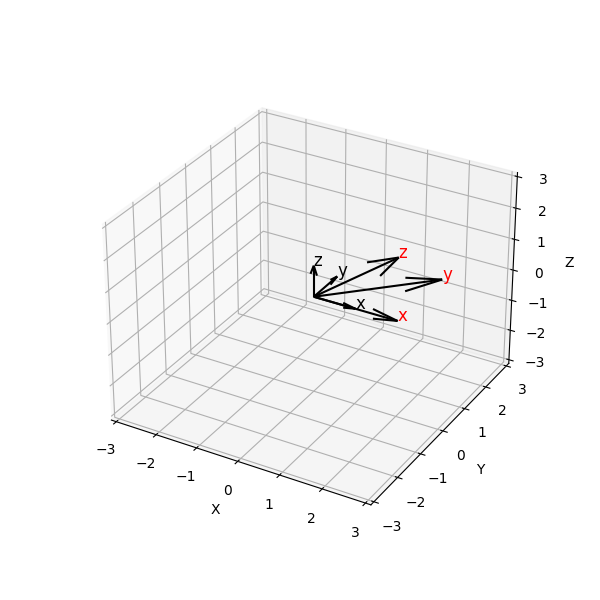

In [12]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# Transformation
transformation = [[2,2,2],[0,2,0],[0,0,2]]

# Vector coordinates
v = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

apply_transformation(transformation,v,origin,["x","y","z"],[-3,3,-3,3,-3,3])

<font color='blue'>**Expected output:**  </font>

<img src="./images/example_transformation.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>

## 8.1.3 Rotation matrix

A rotation matrix represents a special linear transformation that rotates vectors preserving their length.

$$
\mathbf{R} = 
\begin{bmatrix} 
r_{11} & r_{12} & r_{13} \\ 
r_{21} & r_{22} & r_{23} \\ 
r_{32} & r_{32} & r_{33} \end{bmatrix} 
= \underbrace{[r_x \ r_y \ r_z]}_{\text{coordinates of the original}\\ \text{basis in the new one}} \in \mathbb{R}^{3x3}
$$

In this way, let's say that we have a certain vector $\mathbf{p}^W$ that represents the coordinates of a point in a certain reference system that we will call `WORLD` (note the superscript): $\mathbf{p}^W=[p_x,p_y,p_z]^\texttt{T}$. Now, we can rotate it around the origin of coordinates and obtain its new coordinates through:

$$
{\mathbf{p}^W}' = \mathbf{R}\mathbf{p}^W 
\ \ \rightarrow \ \ 
\begin{bmatrix} 
p_x' \\ p_y' \\ p_z' 
\end{bmatrix} 
= 
\mathbf{R} 
\begin{bmatrix} 
p_x \\ p_y \\ p_z 
\end{bmatrix}
$$

If we go back to our graphical engine for the videogame, this could correspond to the case of *a point rotating around the camera* (e.g. a bird flying around you), and is called **active rotation**, because it is the point who is rotating around the reference system.

The following code exemplifies one of these rotations (in 2D):

<IPython.core.display.Javascript object>


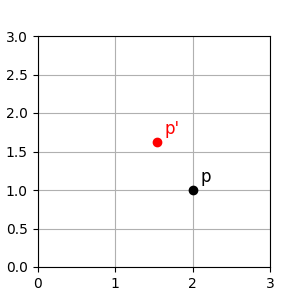

In [13]:
p = np.array([2, 1]).T; # defines the point

alpha = radians(20) # 20 degrees 
R = np.array([[cos(alpha),-sin(alpha)],[sin(alpha),cos(alpha)]]) # Defines the rotation matrix

p_prima = R @ p # Applies the rotation

# Show the results!
fig = plt.figure(figsize=(3, 3))
plt.plot(p[0],p[1],'ko')
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.plot(p_prima[0],p_prima[1],'ro')
plt.grid()
plt.text(p[0]+0.1, p[1]+0.1, "p", fontsize=12)
plt.text(p_prima[0]+0.1, p_prima[1]+0.1, "p'", fontsize=12,color="red");

But we can use the rotation matrix not only to rotate points but also to **express rotations between different reference systems**. Imagine now that we have two coordinate systems: a global one, which we will call `WORLD` and a local one, which we will denote by `CAMERA`. And, not only that, the `CAMERA` reference system is rotated w.r.t. the `WORLD` according to a certain rotation matrix $\mathbf{R}^W_C$. *Note: The subscript and superscript in the notation of the $\mathbf{R}^W_C$ matrix indicates that it must be understood as the rotation of the `CAMERA` reference frame as seen from the `WORLD` one*.

Now, imagine we have a certain point $\mathbf{p}^C$ with coordinates in the `CAMERA` reference system $\mathbf{p}^C=[p_x,p_y,p_z]^\texttt{T}$ and we want to know its coordinates $\mathbf{q}^W=[q_x,q_y,q_z]^\texttt{T}$ **within** the `WORLD`. 

<table>
    <tr><td><img src="./images/rotation.png" width="300" align="center"/></td></tr>
    <tr><td><center>Figure 1</center></td></tr>
</table>

Well, this can be computed with the exact same equation!:
$$
\mathbf{q}^W = \mathbf{R}^W_C\mathbf{p}^C \rightarrow 
\begin{bmatrix} 
q_x \\ q_y \\ q_z 
\end{bmatrix} = 
\mathbf{R}^W_C
\begin{bmatrix} 
p_x \\ p_y \\ p_z 
\end{bmatrix}
$$

To understand this, let's have a look to the figure above. Note that determining the coordinates of the blue point within the global reference system (in black) is the same that rotating the blue point within the local reference system (in orange) and getting its new coordinates, and that's why they are computed exactly the same way! Doing this we could know the coordinates of the bird in the `WORLD`.

But one step further, imagine that we want now to do exactly the **opposite**, that is, knowing the value of the global coordinates $\mathbf{q}^W$, obtaining the local coordinates $\mathbf{p}^C$ in the rotated reference system. That is, you know the coordinates of the bird in the `WORLD` reference system, but you need them in the `CAMERA` coordinate system. In this case we can use the **inverse of the rotation matrix** to obtain them:

$$
\mathbf{p}^C = \left(\mathbf{R}^W_C\right)^{-1}\mathbf{q}^W = 
\left(\mathbf{R}^W_C\right)^\texttt{T}\mathbf{q}^W = 
\left(\mathbf{R}^C_W\right)\mathbf{q}^W
\rightarrow 
\begin{bmatrix} 
p_x \\ p_y \\ p_z 
\end{bmatrix} = 
\mathbf{R}^\texttt{T}
\begin{bmatrix} 
q_x \\ q_y \\ q_z 
\end{bmatrix}
$$

In this case, we can understand this as if the point was **static** in the environment and it is the camera (or the player point-of-view, if you want) which is rotating within it. This is called **passive rotation**.

*Note: It is **really important** to understand that, in these equations, $\mathbf{R}^W_C$ represents the rotation of the `CAMERA` reference system with respect to the `WORLD` reference system while $\mathbf{R}^C_W$ represents the other way around.*

You might also have noticed in this equation that we wrote that $\left(\mathbf{R}^W_C\right)^{-1} = \left(\mathbf{R}^W_C\right)^\texttt{T}$, and that is because rotation matrices are **orthogonal**, hence fulfilling these two properties:

- Its inverse equals its transpose: $\mathbf{R}^\texttt{T}\mathbf{R} = \mathbf{R}\mathbf{R}^\texttt{T} = \mathbf{I} \rightarrow \mathbf{R}^\texttt{T} = \mathbf{R}^{-1}$
- $\mathbf{R}$ also verifies that $\ \texttt{det}(\mathbf{R}) = +1$

*Note: So, remember, if $\mathbf{R}$ is the rotation matrix between systems `A` and `B`, then $\mathbf{R}^\texttt{T}$ is the rotation matrix between system `B` and `A`.*

### 3D rotations

Focusing now on rotations in 3D-space, we can define **three elemental rotations**, one in each axis $Z$, $Y$ and $X$, denoted by *yaw*, *pitch* and *roll*, respectively:

<img src="./images/rotation_plane.png" width="500" align="center"/>

These elemental rotations are represented by three different matrices:

$\hspace{2cm}\mathbf{R}_z(\theta) = \begin{bmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix} \hspace{1cm} \mathbf{R}_y(\theta) = \begin{bmatrix} cos\theta & 0 & sin\theta \\ 0 & 1 & 0 \\ -sin\theta & 0 & cos\theta \end{bmatrix} \hspace{1cm} \mathbf{R}_x(\theta) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & cos\theta & -sin\theta \\ 0 & sin\theta & cos\theta \end{bmatrix}\\[5pt]$

*Note: These elemental rotation matrices keep static the transformation in a certain axis, (e.g. pitch rotation does not modify the $y$ values).*

Using each one of these matrices rotates a vector in one axis, but **what if we want to perform more than one rotation at a time?** Well, we just need to multiply them in a certain order!

$$
\mathbf{R}
= 
\begin{bmatrix} 
r_{11} & r_{12} & r_{13} \\ 
r_{21} & r_{22} & r_{23} \\ 
r_{31} & r_{32} & r_{33} 
\end{bmatrix} 
= 
\mathbf{R}_z(\alpha)\mathbf{R}_y(\beta)\mathbf{R}_x(\theta) 
$$

where $\alpha$ = *yaw* angle, $\beta$ = *pitch* angle and $\theta$ = *roll* angle.

**But why the order of the multiplication matters?** Because matrix multiplication is not commutative! They are several different orders how these matrices can be multiplied but the one presented here (i.e. $Z-Y-X$) is one of the most used (for example in fields like robotics, airborne navigation, etc.). 

This sequence means that:
- First, the original reference system is rotated a certain $\alpha$ angle around its $Z$ axis, 
- Then the resulting (**rotated**) system is rotated again a certain $\beta$ angle around its **rotated** $Y'$ axis
- And finally it is rotated again a certain $\theta$ angle around its **rotated** $X''$ axis.

<img src="./images/rotation_order.png" width="900" align="center"/>

Note that each rotation is applied to the rotated axis (this is called *intrinsic* rotation) and it is performed through **post-multiplication**. If we wanted to rotate around the original (unrotated axis) we would have used pre-multiplication (this is called *extrinsic* rotation). In general this second approach is less intuitive and the first one is preferred. So, just keep the stated order when multiplying elemental rotations.

### Wait, but, what about translations?

If we focus on general transformations between reference systems, you can imagine that **usually cameras are not placed at the center of the `WORLD` coordinate system**, but they are moving within the world, that is, they don't share their origin of coordinates. That means that the camera is also translated w.r.t. the `WORLD` reference system, so we have to include a translation vector $\mathbf{t}^W_C$ in order to be able to transform points between the two reference frames, not only rotate them!

Let's go back to Figure 1 and update it with a more general transformation (remember, {Q} is the `WORLD` reference system and {P} is the `CAMERA` one):
<table>
    <tr><td><img src="./images/rotation_and_translation.png" width="300" align="center"/></td></tr>
    <tr><td><center>Figure 2</center></td></tr>
</table>

Now that the transformation between the systems **includes a translation**, we have that:

$$\mathbf{q}^W = \mathbf{R}^W_C \mathbf{p}^C + \mathbf{t}^W_C$$

$$ \begin{bmatrix} q_x \\ q_y \\ q_z \end{bmatrix} 
= 
\begin{bmatrix} 
r_{11} & r_{12} & r_{13} \\ 
r_{21} & r_{22} & r_{23} \\ 
r_{31} & r_{32} & r_{33} 
\end{bmatrix} 
\begin{bmatrix} p_x \\ p_y \\ p_z 
\end{bmatrix} 
+ 
\begin{bmatrix} t_x \\ t_y \\ t_z \end{bmatrix}
$$

Again, in this equation $\mathbf{R}^W_C$ and $\mathbf{t}^W_C$ express the rotation and translation, respectively, of the `CAMERA` reference system w.r.t. the `WORLD` one, that is, the position and orientation of the `CAMERA` within the `WORLD`.	

 ## **<span style="color:green"><b><i>ASSIGNMENT 6: Rotating and translating</i></b></span>**
 
Now, we are going to implement the `apply_rotation_translation()` method, which accepts *yaw*, *pitch* and *roll* rotation angles (in degrees) and a translation vector and applies such transformations to an input vector. For that **your are tasked with**:

1. build the $\mathbf{R}_x$, $\mathbf{R}_y$ and $\mathbf{R}_z$ matrices, and combine them into the $\mathbf{R}$ one, 
2. apply the rotation to the input vectors, 
3. apply the translation to the result of the previous step, and
4. show both, the initial set of vectors and the transformed one.

*Tip: you can transform degrees to radians using [`radians()`](https://www.geeksforgeeks.org/degrees-and-radians-in-python/).*

In [14]:
# ASSIGNMENT 6
def apply_rotation_translation(v, origin, yaw, pitch, roll, translation, labels, axes_lim):
    """ Apply a linear transformation to a set of 3D-vectors and plot them
        
        Args:
            v: Array containing vector coordinates, each column contains a 3D vector
            origin: Array containing vector origin points for 'v' array.
            yaw: Degrees to rotate the coordinate system around the 'Z' axis 
            pitch: Degrees to rotate the coordinate system around the 'Y' axis 
            roll: Degrees to rotate the coordinate system around the 'X' axis 
            translation: Column vector containing the translation for each axis
            labels: Array of strings containing labels for the vectors, it should have same length than columns in 'v'
            axes_lim: 6-size vector containing the minimum and maximum limits for each axis [X_min,X_max,X_min,X_max,Z_min,Z_max]
    """   
    # Write your code here!
    
    # Transform to radians
    yaw = radians(yaw)
    pitch = radians(pitch)
    roll = radians(roll)
    
    # 1. Construct rotation matrices
    Rx = np.array([
        [1, 0, 0],
        [0, cos(roll), -sin(roll)],
        [0, sin(roll), cos(roll)] 
    ])
    Ry = np.array([
        [cos(pitch), 0, sin(pitch)],
        [0, 1, 0],
        [-sin(pitch), 0, cos(pitch)]
    ])
    Rz = np.array([
        [cos(yaw), -sin(yaw), 0],
        [sin(yaw), cos(yaw), 0],
        [0,0,1]
    ])
    
    # Combine rotation matrices
    R = Rz @ Ry @ Rx
    
    # Apply transformation
    transformed_v = R @ v # apply rotation
    transformed_origin = origin + translation # apply translation
    
    # Create figure
    fig = plt.figure()

    # Prepare figure for 3D data
    ax = fig.gca(projection='3d')

    # Call plot_vectors
    fig, ax = plot_vectors(fig, ax, v, origin, labels, "black", axes_lim)
    fig, ax = plot_vectors(fig, ax, transformed_v, transformed_origin, labels, "red", axes_lim)

    plt.show()

You can use next code **to test if your results are correct**:

<IPython.core.display.Javascript object>


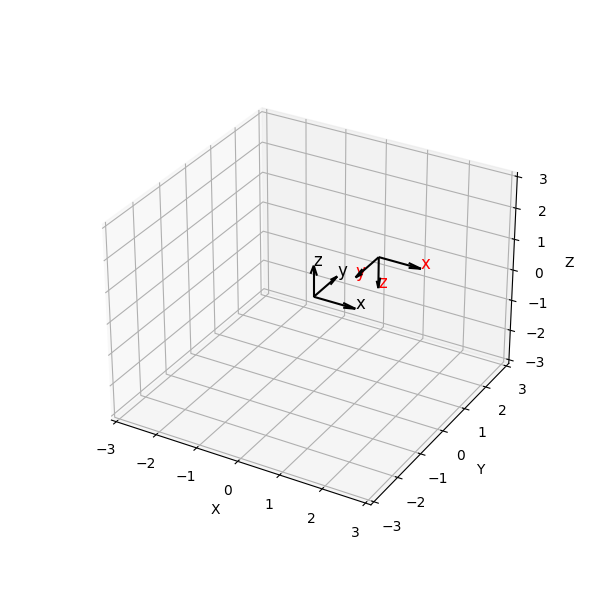

In [15]:
# Vector coordinates
v = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Traslation vector
translation = np.array([[1],[1],[1]])

# Apply transformation
apply_rotation_translation(v,origin,0,0,180,translation,["x","y","z"],[-3,3,-3,3,-3,3])

<font color='blue'>**Expected output:**  </font>

<img src="./images/example_transformation_2.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>

These transformations are strongly related to a camera system in a videogame. For example, it could represent a movement of the player where he/she jumps and rotates. That is, we are moving the `CAMERA` reference system within the `WORLD` one. Next, **you are asked to** simulate the following camera movements in such a context, using the previously defined method.

- Look to the **right 90 degrees** and walk **forward 2 units**

<IPython.core.display.Javascript object>


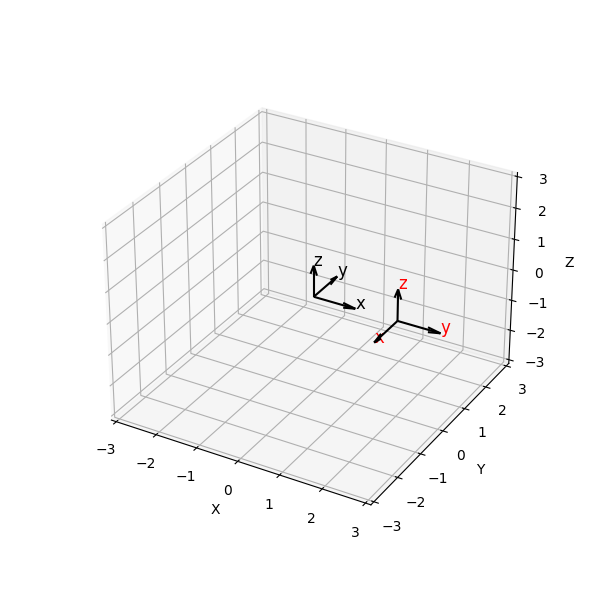

In [16]:
# Write your code here!


# Vector coordinates
v = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Traslation vector
translation = np.array([[2],[0],[0]])

# Apply transformation
apply_rotation_translation(v,origin,-90,0,0,translation,["x","y","z"],[-3,3,-3,3,-3,3])

<font color='blue'>**Expected output:**  </font>

<img src="./images/example_transformation_3.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>


- While you are walking (**two units forward**), jump (our character can **jump one unit of height**), and look **45 degrees to the floor** (e.g. jumping an obstacle).

<IPython.core.display.Javascript object>


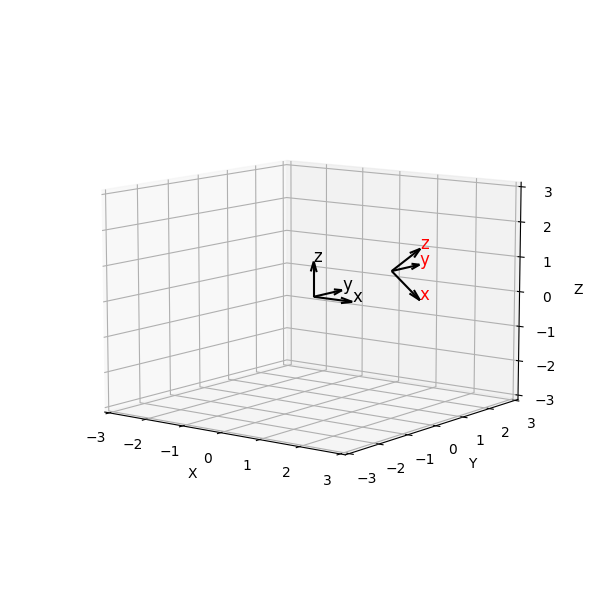

In [17]:
# Write your code here!

# Vector coordinates
v = np.array([[1,0,0],[0,1,0],[0,0,1]])

# Origin coordinates
origin = np.array([[0,0,0],[0,0,0],[0,0,0]])

# Traslation vector
translation = np.array([[2],[0],[1]])

# Apply transformation
apply_rotation_translation(v,origin,0,45,0,translation,["x","y","z"],[-3,3,-3,3,-3,3])

<font color='blue'>**Expected output:**  </font>

<img src="./images/example_transformation_4.png" width="500" align="left"/>
<img src="./images/blank.png" width="100" align="rigth"/>


## Conclusion

Awesome!

This was an introductory notebook covering some mathematical tools that are the building blocks for image formation. We made an excellent work trying to master these maths and we have learned:

- How to plot vectors and perform products between them.
- The ideas behind the linear transformation of vectors.
- How to rotate and translate points or vectors using Cartesian coordinates.